In [18]:
import os
import pyro
import pyro.distributions as dist
import torch

import pandas as pd
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
import json # Added for parsing JSON
from sklearn.preprocessing import MultiLabelBinarizer # Added for one-hot encoding

# Load the dataset and drop nans
df = pd.read_csv("tmdb_5000_movies.csv")
df.dropna(subset=['overview'], inplace=True)
vectorizer = CountVectorizer(max_df=0.80, min_df=0.05, stop_words='english')
docs = torch.from_numpy(vectorizer.fit_transform(df['overview']).toarray())

vocab = pd.DataFrame(columns=['word', 'index'])
vocab['word'] = vectorizer.get_feature_names_out()
vocab['index'] = vocab.index
print('Dictionary size: %d' % len(vocab))
print('Corpus size: {}'.format(docs.shape))
rating = df['vote_average'].values

# onehot encode genres
# df['genres'][0] is '[{"id": 28, "name": "Action"}, {"id": 12, "name": "Adventure"}, {"id": 14, "name": "Fantasy"}, {"id": 878, "name": "Science Fiction"}]'

# Function to parse JSON and extract genre names
def extract_genres(json_str):
    try:
        genres_list = json.loads(json_str)
        return [genre['name'] for genre in genres_list]
    except (TypeError, json.JSONDecodeError):
        return []

df['genre_list'] = df['genres'].apply(extract_genres)

mlb = MultiLabelBinarizer()
genre_onehot = pd.DataFrame(mlb.fit_transform(df['genre_list']), columns=mlb.classes_, index=df.index)

# You can now concatenate this with the original df if needed, or use genre_onehot directly
# For example: df = pd.concat([df, genre_onehot], axis=1)
#print("Shape of one-hot encoded genres: {}".format(genre_onehot.shape))
#print("First 5 rows of one-hot encoded genres:")
#print(genre_onehot.head())

# The variable 'genre' seems to be defined later from df['genres'].values
# If you need 'genre' as a numpy array of the original string values:
genre = df['genres'].values


Dictionary size: 26
Corpus size: torch.Size([4800, 26])


In [38]:
df = pd.read_csv("IMDB.csv")
df.dropna(inplace=True)
vectorizer = CountVectorizer(max_df=0.80, min_df=20, stop_words='english')
docs = torch.from_numpy(vectorizer.fit_transform(df['review']).toarray())
#mlb = MultiLabelBinarizer()
#onehot encode (sentiment)
# df['sentiment'][0] is 'positive' or 'negative'

one_hot = pd.get_dummies(df['sentiment'])
#genre_onehot = mlb.fit_transform(df['sentiment'])


In [49]:
genre_onehot = one_hot['positive'].values[:, np.newaxis]

In [42]:
import math
import torch.nn as nn
import torch.nn.functional as F
from pyro.infer import SVI, TraceMeanField_ELBO
from tqdm import trange

In [43]:
class Encoder(nn.Module):
    # Base class for the encoder net, used in the guide
    def __init__(self, vocab_size, num_topics, hidden, dropout):
        super().__init__()
        self.drop = nn.Dropout(dropout)  # to avoid component collapse
        self.fc1 = nn.Linear(vocab_size, hidden)
        self.fc2 = nn.Linear(hidden, hidden)
        self.fcmu = nn.Linear(hidden, num_topics)
        self.fclv = nn.Linear(hidden, num_topics)
        # NB: here we set `affine=False` to reduce the number of learning parameters
        # See https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html
        # for the effect of this flag in BatchNorm1d
        self.bnmu = nn.BatchNorm1d(num_topics, affine=False)  # to avoid component collapse
        self.bnlv = nn.BatchNorm1d(num_topics, affine=False)  # to avoid component collapse

    def forward(self, inputs):
        h = F.softplus(self.fc1(inputs))
        h = F.softplus(self.fc2(h))
        h = self.drop(h)
        # μ and Σ are the outputs
        logtheta_loc = self.bnmu(self.fcmu(h))
        logtheta_logvar = self.bnlv(self.fclv(h))
        logtheta_scale = (0.5 * logtheta_logvar).exp()  # Enforces positivity
        return logtheta_loc, logtheta_scale


class Decoder(nn.Module):
    # Base class for the decoder net, used in the model
    def __init__(self, vocab_size, num_topics, dropout):
        super().__init__()
        self.beta = nn.Linear(num_topics, vocab_size, bias=False)
        self.bn = nn.BatchNorm1d(vocab_size, affine=False)
        self.drop = nn.Dropout(dropout)

    def forward(self, inputs):
        inputs = self.drop(inputs)
        # the output is σ(βθ)
        return F.softmax(self.bn(self.beta(inputs)), dim=1)


class ProdLDA(nn.Module):
    def __init__(self, vocab_size, num_topics, hidden, dropout):
        super().__init__()
        self.vocab_size = vocab_size
        self.num_topics = num_topics
        self.encoder = Encoder(vocab_size, num_topics, hidden, dropout)
        self.decoder = Decoder(vocab_size, num_topics, dropout)

    def model(self, docs):
        pyro.module("decoder", self.decoder)
        with pyro.plate("documents", docs.shape[0]):
            # Dirichlet prior 𝑝(𝜃|𝛼) is replaced by a logistic-normal distribution
            logtheta_loc = docs.new_zeros((docs.shape[0], self.num_topics))
            logtheta_scale = docs.new_ones((docs.shape[0], self.num_topics))
            logtheta = pyro.sample(
                "logtheta", dist.Normal(logtheta_loc, logtheta_scale).to_event(1))
            theta = F.softmax(logtheta, -1)

            # conditional distribution of 𝑤𝑛 is defined as
            # 𝑤𝑛|𝛽,𝜃 ~ Categorical(𝜎(𝛽𝜃))
            count_param = self.decoder(theta)
            # Currently, PyTorch Multinomial requires `total_count` to be homogeneous.
            # Because the numbers of words across documents can vary,
            # we will use the maximum count accross documents here.
            # This does not affect the result because Multinomial.log_prob does
            # not require `total_count` to evaluate the log probability.
            total_count = int(docs.sum(-1).max())
            pyro.sample(
                'obs',
                dist.Multinomial(total_count, count_param),
                obs=docs
            )

    def guide(self, docs):
        pyro.module("encoder", self.encoder)
        with pyro.plate("documents", docs.shape[0]):
            # Dirichlet prior 𝑝(𝜃|𝛼) is replaced by a logistic-normal distribution,
            # where μ and Σ are the encoder network outputs
            logtheta_loc, logtheta_scale = self.encoder(docs)
            logtheta = pyro.sample(
                "logtheta", dist.Normal(logtheta_loc, logtheta_scale).to_event(1))

    def beta(self):
        # beta matrix elements are the weights of the FC layer on the decoder
        return self.decoder.beta.weight.cpu().detach().T

In [44]:
class GenrePredictor(nn.Module):
    # Module for predicting genres from topic distributions
    def __init__(self, num_topics, num_genres, hidden_dim, dropout):
        super().__init__()
        self.fc1 = nn.Linear(num_topics, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_genres)
        self.drop = nn.Dropout(dropout)
        
    def forward(self, theta):
        h = F.relu(self.fc1(theta))
        h = self.drop(h)
        # Output probabilities for each genre class
        return torch.sigmoid(self.fc2(h))


class ProdLDA(nn.Module):
    def __init__(self, vocab_size, num_topics, hidden, dropout, num_genres=None, hidden_dim_genre=100):
        super().__init__()
        self.vocab_size = vocab_size
        self.num_topics = num_topics
        self.num_genres = num_genres
        self.encoder = Encoder(vocab_size, num_topics, hidden, dropout)
        self.decoder = Decoder(vocab_size, num_topics, dropout)
        
        # Add genre predictor if num_genres is provided
        if num_genres is not None:
            self.genre_predictor = GenrePredictor(num_topics, num_genres, hidden_dim_genre, dropout)
        else:
            self.genre_predictor = None

    def model(self, docs, genres=None):
        pyro.module("decoder", self.decoder)
        if self.genre_predictor is not None:
            pyro.module("genre_predictor", self.genre_predictor)
            
        with pyro.plate("documents", docs.shape[0]):
            # Dirichlet prior 𝑝(𝜃|𝛼) is replaced by a logistic-normal distribution
            logtheta_loc = docs.new_zeros((docs.shape[0], self.num_topics))
            logtheta_scale = docs.new_ones((docs.shape[0], self.num_topics))
            logtheta = pyro.sample(
                "logtheta", dist.Normal(logtheta_loc, logtheta_scale).to_event(1))
            theta = F.softmax(logtheta, -1)

            # conditional distribution of 𝑤𝑛 is defined as
            # 𝑤𝑛|𝛽,𝜃 ~ Categorical(𝜎(𝛽𝜃))
            count_param = self.decoder(theta)
            total_count = int(docs.sum(-1).max())
            pyro.sample(
                'obs',
                dist.Multinomial(total_count, count_param),
                obs=docs
            )
            
            # Genre prediction if genres are provided
            if genres is not None and self.genre_predictor is not None:
                genre_probs = self.genre_predictor(theta)
                # For each genre dimension, use a Bernoulli distribution
                # since genres are one-hot encoded (multi-label classification)
                for i in range(self.num_genres):
                    pyro.sample(
                        f"genre_{i}",
                        dist.Bernoulli(genre_probs[:, i]),
                        obs=genres[:, i]
                    )

    def guide(self, docs, genres=None):
        pyro.module("encoder", self.encoder)
        with pyro.plate("documents", docs.shape[0]):
            # Dirichlet prior 𝑝(𝜃|𝛼) is replaced by a logistic-normal distribution,
            # where μ and Σ are the encoder network outputs
            logtheta_loc, logtheta_scale = self.encoder(docs)
            logtheta = pyro.sample(
                "logtheta", dist.Normal(logtheta_loc, logtheta_scale).to_event(1))

    def beta(self):
        # beta matrix elements are the weights of the FC layer on the decoder
        return self.decoder.beta.weight.cpu().detach().T
        
    def predict_genres(self, docs):
        """
        Predict genres for the given documents
        
        Args:
            docs: Document word counts tensor
            
        Returns:
            genre_probs: Probabilities for each genre class
        """
        if self.genre_predictor is None:
            raise ValueError("Genre predictor not initialized. Set num_genres when creating the model.")
            
        # Get the topic proportions using the encoder
        with torch.no_grad():
            logtheta_loc, _ = self.encoder(docs)
            theta = F.softmax(logtheta_loc, dim=-1)
            
            # Get genre probabilities using the genre predictor
            genre_probs = self.genre_predictor(theta)
            
        return genre_probs

In [54]:
import os
import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS
import torch

assert pyro.__version__.startswith('1.9.1')
# Enable smoke test - run the notebook cells on CI.
smoke_test = 'CI' in os.environ


# setting global variables
seed = 0
torch.manual_seed(seed)
pyro.set_rng_seed(seed)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

num_topics = 20 if not smoke_test else 3
docs = docs.float().to(device)
batch_size = 128
learning_rate = 1e-3
num_epochs = 100 if not smoke_test else 1

In [55]:
# clear parameters
pyro.clear_param_store()

# Convert genre_onehot to a tensor

genre_tensor = torch.tensor(genre_onehot, dtype=torch.float32).to(device) #.values

# Update model initialization with number of genres
prodLDA = ProdLDA(
    vocab_size=docs.shape[1],
    num_topics=num_topics,
    hidden=100 if not smoke_test else 10,
    dropout=0.2,
    num_genres=genre_onehot.shape[1],  # Number of genre classes
    hidden_dim_genre=100 if not smoke_test else 10
)
prodLDA.to(device)

optimizer = pyro.optim.Adam({"lr": learning_rate})
svi = SVI(prodLDA.model, prodLDA.guide, optimizer, loss=TraceMeanField_ELBO())
num_batches = int(math.ceil(docs.shape[0] / batch_size)) if not smoke_test else 1

bar = trange(num_epochs)
for epoch in bar:
    running_loss = 0.0
    for i in range(num_batches):
        batch_docs = docs[i * batch_size:(i + 1) * batch_size, :]
        batch_genres = genre_tensor[i * batch_size:(i + 1) * batch_size, :]
        loss = svi.step(batch_docs, batch_genres)
        running_loss += loss / batch_docs.size(0)
        if i % 10 == 0:
            bar.set_postfix(loss='{:.2e}'.format(loss))

    bar.set_postfix(epoch_loss='{:.2e}'.format(running_loss))

  0%|          | 0/100 [00:00<?, ?it/s]

  2%|▏         | 2/100 [00:43<35:50, 21.94s/it, loss=8.09e+04]      


KeyboardInterrupt: 

TypeError: argument of type 'float' is not iterable

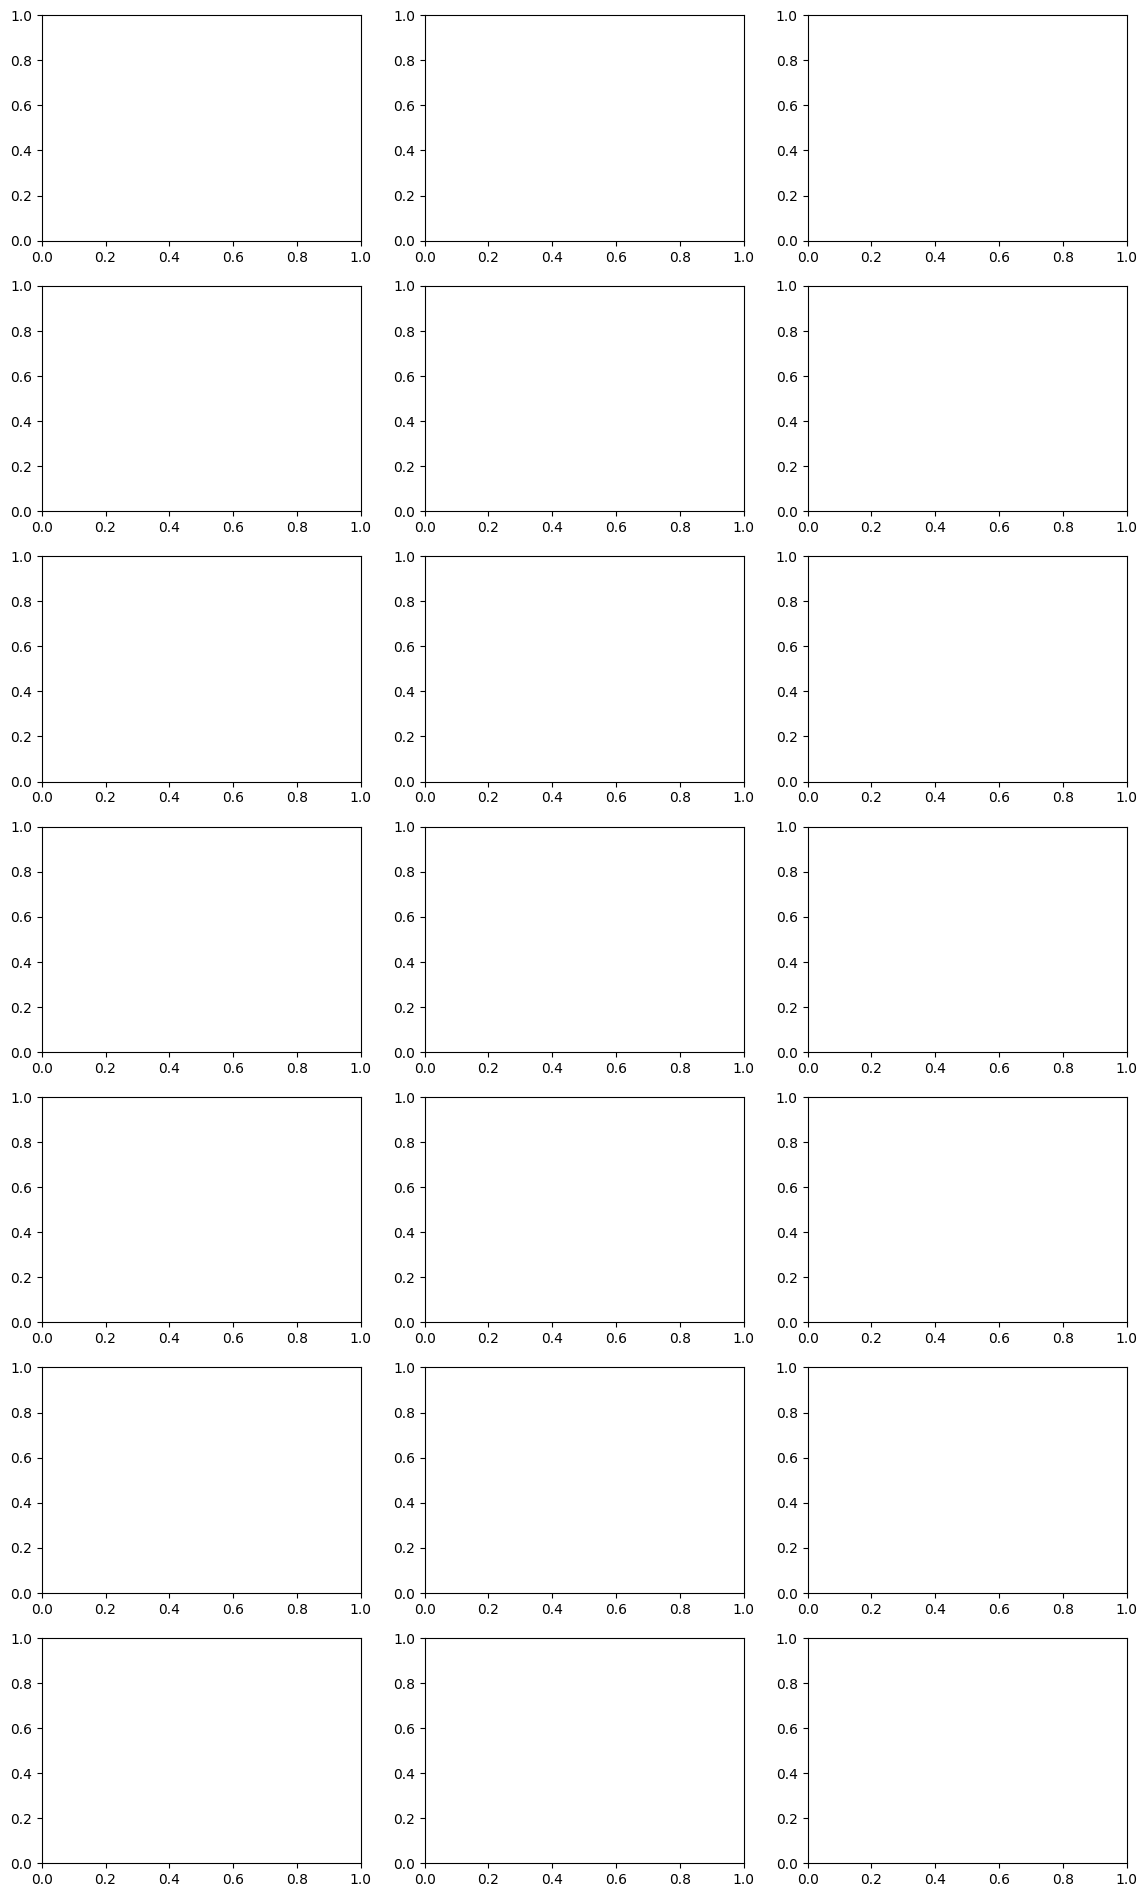

In [56]:
def plot_word_cloud(b, ax, v, n):
    sorted_, indices = torch.sort(b, descending=True)
    df = pd.DataFrame(indices[:100].numpy(), columns=['index'])
    words = pd.merge(df, vocab[['index', 'word']],
                     how='left', on='index')['word'].values.tolist()
    sizes = (sorted_[:100] * 1000).int().numpy().tolist()
    freqs = {words[i]: sizes[i] for i in range(len(words))}
    wc = WordCloud(background_color="white", width=800, height=500)
    wc = wc.generate_from_frequencies(freqs)
    ax.set_title('Topic %d' % (n + 1))
    ax.imshow(wc, interpolation='bilinear')
    ax.axis("off")

if not smoke_test:
    import matplotlib.pyplot as plt
    from wordcloud import WordCloud

    beta = prodLDA.beta()
    fig, axs = plt.subplots(7, 3, figsize=(14, 24))
    for n in range(beta.shape[0]):
        i, j = divmod(n, 3)
        plot_word_cloud(beta[n], axs[i, j], vocab, n)
    axs[-1, -1].axis('off');

    plt.show()

In [8]:
# Evaluate genre prediction performance
if not smoke_test:
    from sklearn.metrics import f1_score, precision_score, recall_score
    
    # Predict genres
    genre_probs = prodLDA.predict_genres(docs)
    genre_preds = (genre_probs > 0.5).float().cpu().numpy()
    genre_true = genre_tensor.cpu().numpy()
    
    # Calculate metrics (micro-averaged for multi-label classification)
    f1 = f1_score(genre_true, genre_preds, average='micro')
    precision = precision_score(genre_true, genre_preds, average='micro')
    recall = recall_score(genre_true, genre_preds, average='micro')
    
    print(f"Genre Prediction Metrics:")
    print(f"F1 Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")

Genre Prediction Metrics:
F1 Score: 0.3540
Precision: 0.5913
Recall: 0.2526


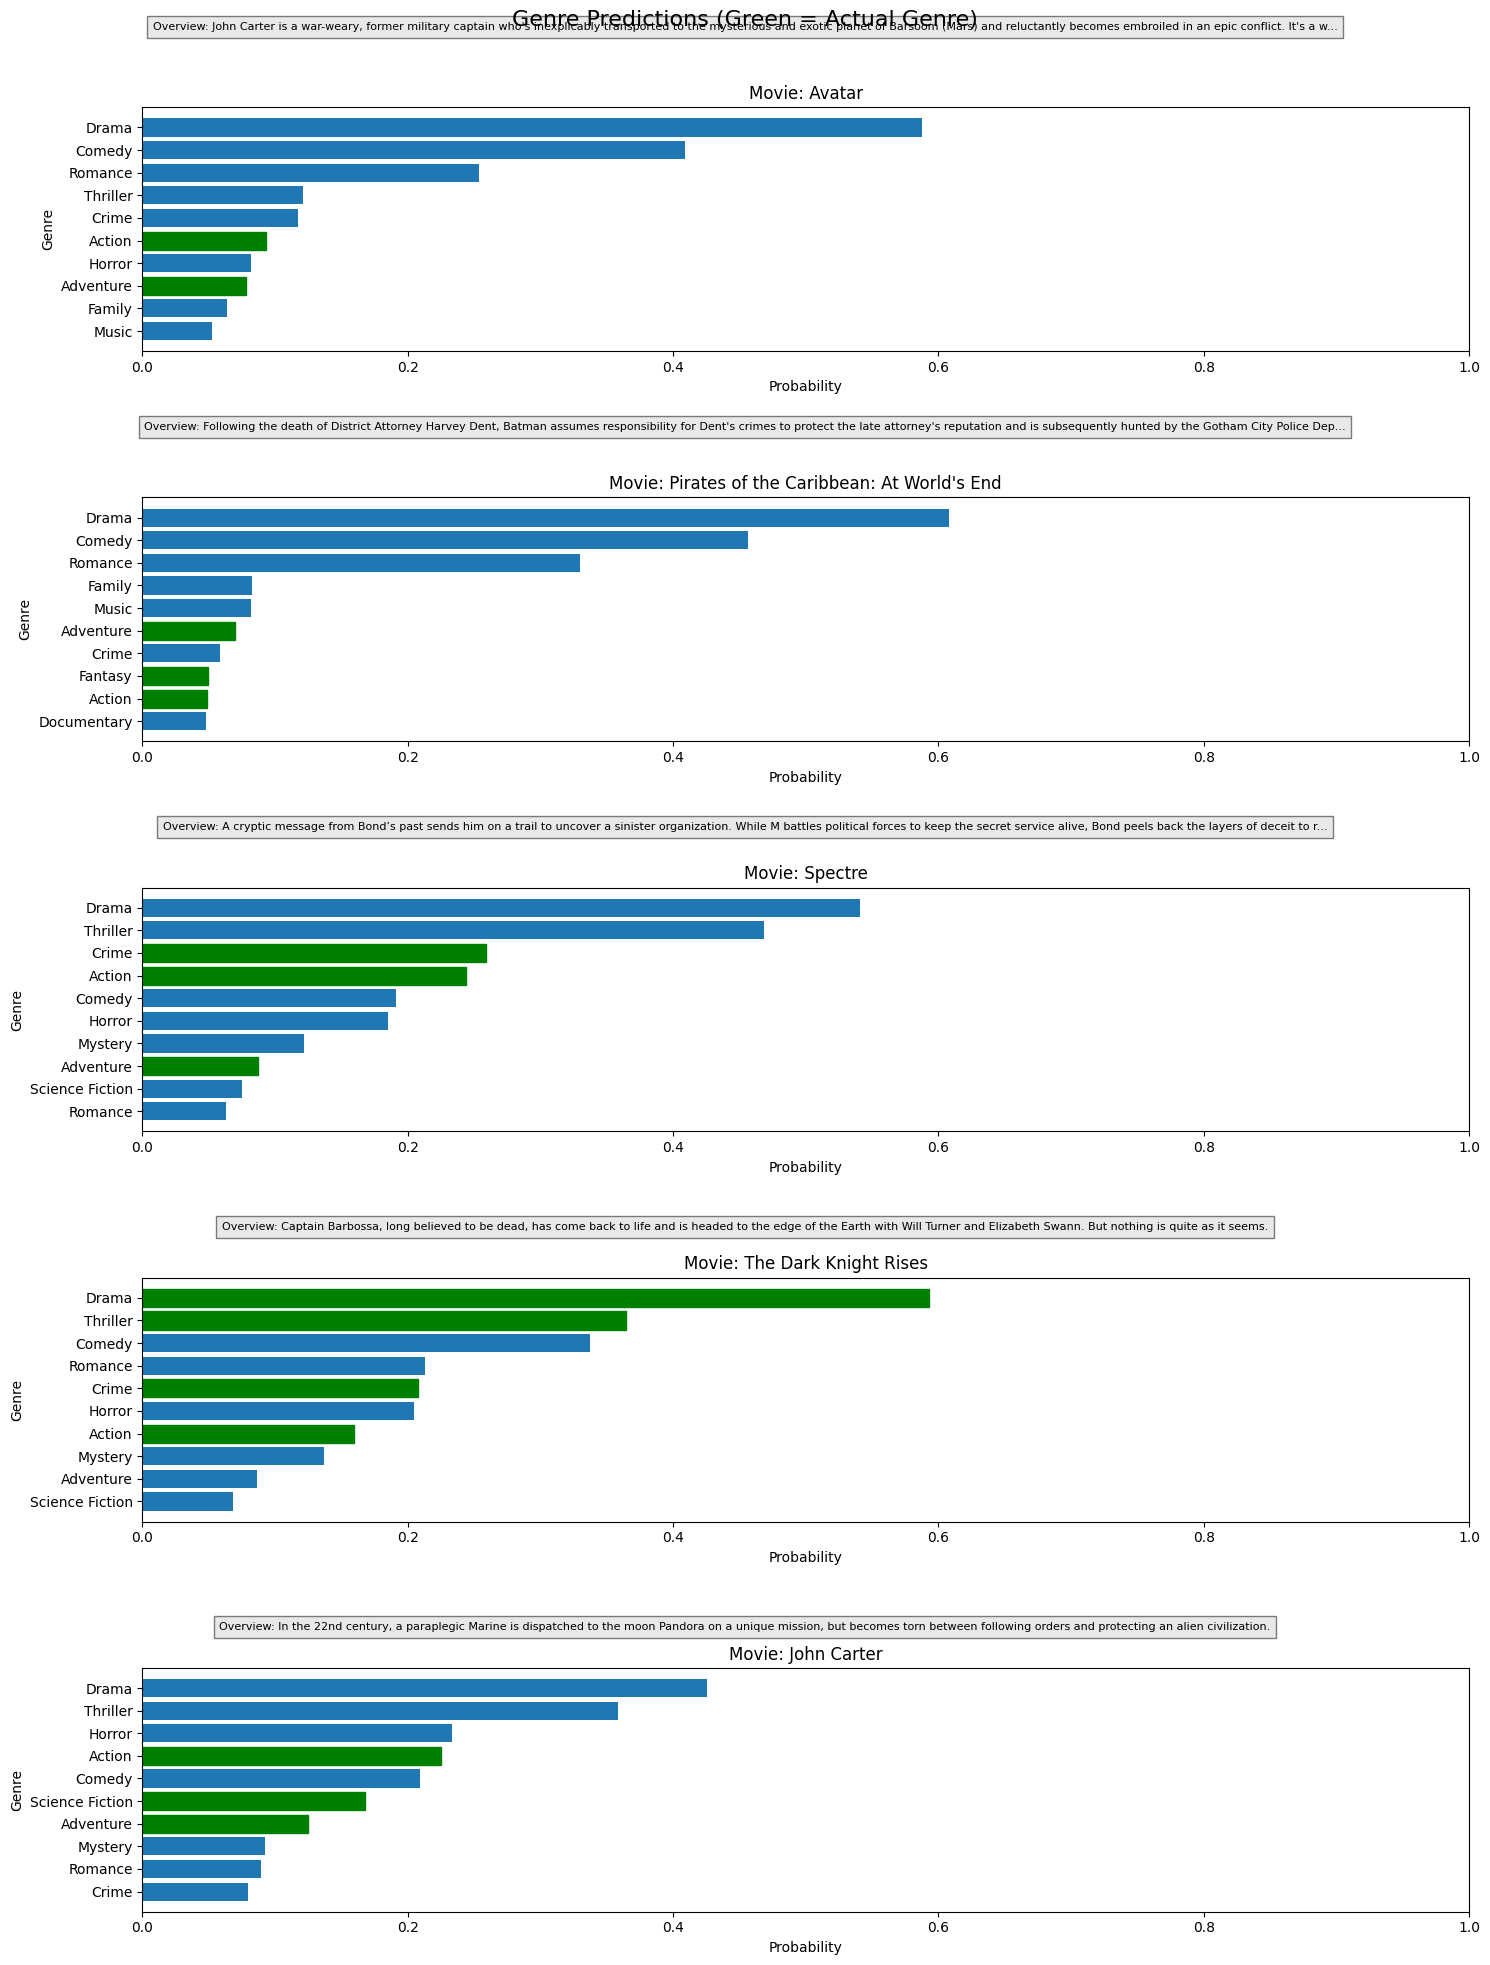

In [9]:
# Visualize genre predictions for a few example documents
if not smoke_test:
    import matplotlib.pyplot as plt
    
    num_examples = 5
    num_genres_to_show = min(10, genre_onehot.shape[1])
    
    # Get genre predictions
    genre_probs = prodLDA.predict_genres(docs[:num_examples])
    
    plt.figure(figsize=(15, 4*num_examples))
    for i in range(num_examples):
        # Get the movie overview for context
        overview = df['overview'].iloc[i]
        movie_title = df['title'].iloc[i] if 'title' in df.columns else f"Movie {i+1}"
        
        # Get actual genres for this movie
        actual_genres = df['genre_list'].iloc[i]
        
        # Get top predicted genres
        probs = genre_probs[i].cpu().numpy()
        indices = np.argsort(probs)[-num_genres_to_show:]
        genre_names = genre_onehot.columns[indices]
        genre_probabilities = probs[indices]
        
        # Plot
        plt.subplot(num_examples, 1, i+1)
        bars = plt.barh(genre_names, genre_probabilities)
        
        # Highlight actual genres
        for j, genre in enumerate(genre_names):
            if genre in actual_genres:
                bars[j].set_color('green')
        
        plt.xlim(0, 1)
        plt.title(f"Movie: {movie_title}")
        plt.xlabel('Probability')
        plt.ylabel('Genre')
        
        # Add overview as text (truncated if too long)
        if len(overview) > 200:
            overview = overview[:200] + "..."
        plt.figtext(0.5, (i+0.85)/num_examples, f"Overview: {overview}", 
                   ha='center', fontsize=8, bbox={"facecolor":"lightgrey", "alpha":0.5})
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.suptitle("Genre Predictions (Green = Actual Genre)", fontsize=16)
    plt.subplots_adjust(hspace=0.6)
    plt.show()